# Sentiment-140 Classification

In this notebook, we will explore the application of transformers for sentiment analysis of different tweets. Our goal is to classify tweets to have either positive or negative sentiment. We will first consider the performance of a pre-trained BERT model, finetuned on the Sentiment-140 dataset, and later we'll develop and train our own transformer architecture from scratch. Let's dive right in!

First of all, we need a couple of useful libraries that you're hopefully familiar with.

In [1]:
import torch
import csv
import numpy as np
from torch.utils.data import Dataset

class SentimentDataset(Dataset):

    def __init__(self, csv_path, training_set=True):
        tweets = []
        labels = []
        with open(csv_path, 'r') as file:
            csv_reader = csv.reader(file)
            for row in csv_reader:
                tweets.append(row[0])
                labels.append(int(row[1]))

        total_tweets = len(tweets)
        train_indices = np.random.choice(total_tweets, int(0.8 * total_tweets), replace=False)
        test_indices = np.setdiff1d(np.arange(total_tweets), train_indices)

        if training_set:
            self.tweets = [tweets[i] for i in train_indices]
            self.labels = [labels[i] for i in train_indices]
        else:
            self.tweets = [tweets[i] for i in test_indices]
            self.labels = [labels[i] for i in test_indices]

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        return self.tweets[idx], self.labels[idx]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# this automatically reloads the libraries so you can update them dynamically
%load_ext autoreload
%autoreload 2

## Loading our data

Let's start by preparing our dataset. We have implemented the dataset class for you in `data_utils/SentimentDataset.py`, feel free to check the implementation. However, before we can use the `SentimentDataset` class to create our train data and test data objects, we need to pre-process the raw data.

You can download raw data from [here](https://www.kaggle.com/datasets/kazanova/sentiment140). If you examine the raw data file, you can see that there is a lot of redundant information such as the time of each tweet or usernames. For our sentiment analysis, we simply need the tweets and ground truth labels. To preprocess the data file, simply paste the original CSV file in the root project directory without changing the file name and run the script `preprocess_dataset.py`. This should create a new CSV file called `dataset.csv`. (The reason why we do not include the data files on the GitHub repository is that they are simply too big.) Then, you're ready to create a dataset and dataloader below.

Notice that the original dataset contains 1.6 million tweets; that is huge! Therefore, it may take forever to train on so much data, especially if you happen not to have access to a fast GPU (talk to the officers about getting access to the ACM AI server!). Therefore, in the next cell you can configure whether to use the whole dataset or just a subset of it.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
use_subset_of_data = True
subset_percentage = 0.05 # set the percentage of original dataset size you'd like to use

In [5]:
train_data = SentimentDataset('/content/drive/MyDrive/dataset.csv', training_set=True)
test_data = SentimentDataset('/content/drive/MyDrive/dataset.csv', training_set=False)

if use_subset_of_data:
    train_set_len = int(subset_percentage * len(train_data))
    test_set_len = int(subset_percentage * len(test_data))

    train_subset_indices = np.random.choice(len(train_data), size=train_set_len, replace=False)
    train_sampler = SubsetRandomSampler(train_subset_indices)

    test_subset_indices = np.random.choice(len(test_data), size=test_set_len, replace=False)
    test_sampler = SubsetRandomSampler(test_subset_indices)

    train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(test_data, batch_size=32, sampler=test_sampler)

else:
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Let's examine a sample tweet from the dataset and print its corresponding ground truth label. Label 1 corresponds to positive sentiment, while label 0 stands for negative sentiment. You can run the cell below multiple times to see different tweets.

In [6]:
tweets, labels = next(iter(train_loader))
print("Sample tweet: ", tweets[0])
print("Ground truth label: ", labels[0].numpy())

Sample tweet:  I got to see one of my best buddies for about 15 minutes and I just realized he's gone and I won't see him for a while  dangit
Ground truth label:  0


## Fine-tuning BERT

First, let's examine the performance of a pre-trained BERT model on the sentiment analysis task. BERT (original paper [here](https://arxiv.org/abs/1810.04805)) is a language representation model released by Google in 2018 that uses a Bidirectional Transformer architecture.

It can be easily fine-tuned on downstream tasks such as sentiment analysis by appending a classification layer to the original BERT architecture. This is already done automatically by importing the `BertForSequenceClassification` from the Hugging Face library called `transformers`. The newly added classification layer is untrained (as you'll see in the warning that appears when you run the following cell) and so we have to fine-tune on the Sentiment-140 data. We will also import a pre-trained tokenizer, which is necessary to convert inputs from natural language to a numerical representation machine learning models can understand. The tokenizer imported from Hugging Face uses WordPiece tokenization, you can learn more about the algorithm [here](https://huggingface.co/learn/nlp-course/en/chapter6/6).

In [7]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
pretrained_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Below, we define a `preprocess` function that takes in the tweets and tokenizes them. The tokenizer will break down words into smaller units called subword tokens and map these words to numbers (IDs), which can be processed by the model. Furthermore, it will add special tokens to the sequence that will normalize inputs to the model.

The `preprocess` function return `input_ids` which represents the tokenized input sequence and `attention_mask` which specifies to the model which tokens to attend to while computing self-attention (more on that later!).

In [8]:
def preprocess(tweets):

    encoded_batch = tokenizer.batch_encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']

    return input_ids, attention_masks

There are three different types of special tokens normally used by the BERT tokenizer. `[CLS]` token is added at the beginning of the input sequence. The final hidden state corresponding to the `[CLS]` token is typically used as the representation of the entire input sequence for classification tasks, so it will be very useful to us later for sentiment analysis. The `[SEP]` token is used to separate different segments of the input sequence. It helps the model distinguish between different parts of the input and process them accordingly. In our case, one `[SEP]` token will typically be added at the end of the tokenized input sequence (tweet). Finally, the `[PAD]` token is used for padding shorter input sequences to a fixed length, so that they can be easily processed in batches without any shape mismatch issues. With BERT, we would typically pad the input sequence to reach a total length of 512 tokens; however, since we're analyzing tweets that are by definition very short, using maximum sequence length of 128 tokens should suffice.

Below, you can see what the IDs reserved for special tokens are.

In [9]:
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
pad_token_id = tokenizer.pad_token_id

print("[CLS] Token ID: " + str(cls_token_id) + ", [SEP] Token ID: " + str(sep_token_id) + ", [PAD] Token ID: " + str(pad_token_id))

[CLS] Token ID: 101, [SEP] Token ID: 102, [PAD] Token ID: 0


We can print a sample tweet and its corresponding tokenized representation. Notice that each input sequence starts with token ID 101 (CLS token), ends with token ID 102 (SEP token), and is padded with token ID 0 (PAD token).

In [10]:
tweets, labels = next(iter(train_loader))
print("Sample tweet: ", tweets[0], '\n')
input_ids, att_masks = preprocess(tweets)
print("Tokenized representation: ", input_ids[0])

Sample tweet:  is sitting in the garden, what a beautiful day  

Tokenized representation:  tensor([ 101, 2003, 3564, 1999, 1996, 3871, 1010, 2054, 1037, 3376, 2154,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


Next, we need to define a training and evaluation loop. Notice that we use the `preprocess` function in both the `train` and `evaluate` to transform the natural language input to tokenized representation. We will also collect loss and accuracy statistics during training, so that we can plot the training history later.

Note that the `finetuning` parameter is used simply because the internal Hugging Face representation of the pre-trained model is slightly different from what our representation will be when we later define our own transformer model. Thus, when using the training loop for fine-tuning the pre-trained downloaded from Hugging Face, set `finetuning=True`, otherwise set it to `False`.

In [11]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs, finetuning=False):

    # Place model on device
    model = model.to(device)

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:

            for inputs, labels in train_loader:

                input_ids, attention_masks = preprocess(inputs)
                # Move inputs and labels to device
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                if finetuning:
                    outputs = outputs.logits
                loss = criterion(outputs, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

                loss_history.append(loss.item())


        avg_loss, accuracy = evaluate(model, val_loader, criterion, device, finetuning)
        print(
            f'Test set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )
        acc_history.append(accuracy)

    return loss_history, acc_history


def evaluate(model, test_loader, criterion, device, finetuning=False):

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:

            input_ids, attention_masks = preprocess(inputs)
            # Move inputs and labels to device
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            if finetuning:
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(outputs, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(labels)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

Make sure you are running the model on CUDA.

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We will finetune all the weights in the BERT model (including the pre-trained weights and the newly initialized classifier weights). An alternative approach would be to freeze the pre-trained weights and only fine-tune the classifier weights. You can do that by passing in `model.classifier.parameters()` to the optimizer instead of passing in all the weights of the model.

In [13]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(pretrained_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=1, finetuning=True)

# Let's save our trained weights
torch.save(pretrained_model.state_dict(), 'bert_fine_tuned.pt')

Epoch 1/1: 100%|██████████| 2000/2000 [21:58<00:00,  1.52it/s, loss=0.368]


Test set: Average loss = 0.3641, Accuracy = 0.8373


Next, let's plot our training loss and test accuracy history that documents the fine-tuning process.

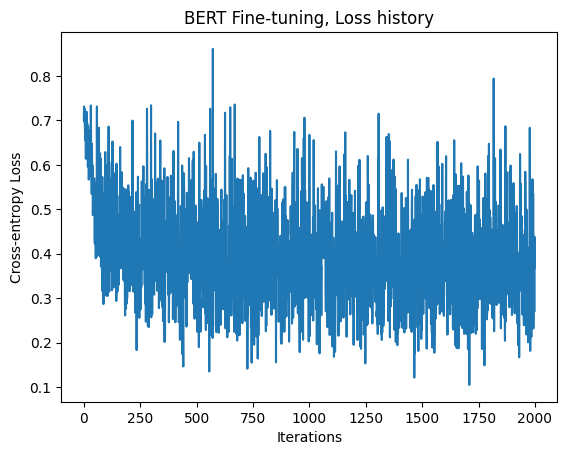

In [14]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT Fine-tuning, Loss history')
plt.show()

Once your model is fine-tuned, feel free to test it on some of your own tweets!!

In [15]:
def classify_tweet(tweet, model, device, finetuning=False):

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():

        tweet = [tweet]
        input_ids, attention_mask = preprocess(tweet)
        # Move inputs and labels to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        output = model(input_ids=input_ids, attention_mask=attention_mask)
        if finetuning:
            output = output.logits

        _, prediction = torch.max(output, dim=1)

    return prediction.cpu()

In [16]:
# Just replace the string below by your own.
sample_tweet = 'Visiting a friend in Santa Barbara today. So fun!!!'

predicted_label = classify_tweet(sample_tweet, pretrained_model, device, finetuning=True)
classification = 'positive' if predicted_label == 1 else 'negative'
print(f'Your tweet was classified as {classification}.')

Your tweet was classified as positive.


## Creating our own Transformer architecture from scratch

That was fun, right? But maybe slightly too easy, don't you think? Let's try to implement our own transformer architecture now, without the help of pre-trained models. We will base our architecture off of BERT, which will also allow us to effectively compare the performance of our own implementation with the pre-trained model. The high-level of the model architecture can be seen below.

Note that, compared to illustration below, all the tensor sizes will most likely be different and specific to the hyperparameters of our model.

![BERT For Sequence Classification](https://github.com/uclaacmai/Tweets-Are-All-You-Need/blob/main/bert_classification.png?raw=true)

![BERT Encoder](https://github.com/uclaacmai/Tweets-Are-All-You-Need/blob/main/bert_encoder.png?raw=true)

Let's first define some hyperparameters of our network.

In [17]:
MAX_SEQ_LEN = 128 # Maximum length of tokenized input sequence (we already covered this above!)
VOCAB_SIZE = 30522 # number of different token -> ID mappings, specific to the BERT Tokenizer (do not change)
N_LAYERS = 12 # number of transformer layers stacked on top of each other
N_HEADS = 12 # number of heads of the transformer, input sequence will be split and equally distributed to each head
EMB_SIZE = 768 # refers to the dimensionality of the vector representations used to encode input tokens
INTERMEDIATE_SIZE = EMB_SIZE * 4 # dimensionality of output of the Intermediate layer
DROPOUT = 0.1 # probability of dropping a neuron during training
N_CLASSES = 2 # we are classifying the sentiment of each tweet simply as POSITIVE or NEGATIVE
LAYER_NORM_EPS = 1e-12 # value used in Layer Norm for numerical stability

## Transformers

Transformers are a type of neural network architecture primarily used in the field of natural language processing (NLP). Unlike previous models that processed inputs sequentially (like RNNs), transformers process whole sequences of data in parallel, which significantly speeds up training.

### Why are they important?

They have been highly successful in a variety of NLP tasks like translation, text summarization, and sentiment analysis due to their ability to handle long-range dependencies in text.

### Components of Transformers

1. Input Embeddings + Positional Encoding
2. Multi-Head Attention
3. Positional-Wise Feed-Forward Networks
4. Layer Normalization and Residual Connections

## 1. Input Embeddings

Converts tokens (words) into vectors of continuous numbers that the model can understand.  

*(Optional)* Check out 3Blue1Brown's video on Word Embeddings [here](https://www.youtube.com/watch?v=wjZofJX0v4M).

### Concept of Embeddings

Embeddings are vector representations of text, where words with **similar meanings** have **similar representations**. These vectors are learned and adjusted during the training of the model to optimize performance on a specific task.

### Importance of Embeddings

Embeddings capture the semantic properties of words, which means they convert the words/tokens into a form that a neural network can work with. This allows the model to **understand and process language** by **quantifying the similarities between different words or phrases**.

### Embeddings in Transformers

1. **Tokenization**:
   - **Process**: Text input is split into tokens (words or subwords), which are then converted into numerical IDs that correspond to entries in the embedding table.
   - **Role in Model**: This step is critical because it translates human-readable text into a format that can be mathematically manipulated by the model.

2. **Lookup Table**:
   - **Process**: Each token ID is used to retrieve its corresponding embedding vector from an embedding matrix (or table) that the model learns during training.
   - **Role in Model**: This embedding matrix acts as the foundational input layer of the transformer, providing a dense and informative representation for each token.

3. **Dimensionality**:
   - **Process**: Embeddings are usually vectors of fixed size (e.g., 256, 512 dimensions), regardless of the vocabulary size.
   - **Role in Model**: Higher dimensions generally capture more detailed semantic information about each token, but also increase model complexity and computational cost.

### Positional Embeddings

If we only turn words into embeddings, the model won't know the order of them in a sentence. We need to somehow preserve the positional info.

- **Concept**: Since transformers process words in parallel rather than sequentially, positional encodings are added to embeddings to give the model information about the order of words in a sentence.
- **Why Necessary**: Helps the model understand how the position of a word in a sentence affects its meaning.

### Training and Adjustments

**Learning Process**:
- Embeddings are not static; they are adjusted during the training process to minimize the model's prediction error. This learning happens through backpropagation, which adjusts the embeddings to better capture the relationships and contexts in which words appear.

**Impact on Performance**:
- The quality of embeddings significantly affects the model's performance. Better embeddings lead to a better understanding of language nuances, such as synonyms, antonyms, and different contexts.

### Toy Example

In [18]:
import torch
import torch.nn as nn

# Vocabulary size and embedding dimension
vocab_size = 1000  # Number of unique tokens
embedding_dim = 64  # Size of each embedding vector

# Create an embedding layer
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Example token IDs
token_ids = torch.LongTensor([10, 200, 500])

# Get embeddings for token IDs
embeddings = embedding_layer(token_ids)
print(embeddings)

tensor([[-0.2571,  0.5149,  0.5225,  0.5391,  0.8416,  0.6975,  2.2726,  0.4504,
          2.3754, -0.5422, -0.3397, -0.6130,  0.1709, -1.6242, -1.3330,  0.3891,
          0.2901, -0.1001, -0.8900,  0.6212,  0.7994,  1.2898, -0.1924,  1.5016,
         -0.2841,  0.3814, -1.2156,  0.1101, -0.1044, -0.1926, -0.2529,  0.0108,
         -0.3002,  0.7983,  1.1577, -0.2041, -1.7266, -2.2349,  0.4517, -1.2827,
         -1.2131, -0.0121, -1.7697, -0.4095,  0.8656,  0.7548,  1.5912,  0.7450,
         -0.4130, -1.2639, -0.1786,  0.8441,  0.8500, -1.3832, -0.9126,  0.4100,
          0.5797,  0.8287, -1.8933, -0.5465,  1.5668,  2.0607, -0.8689, -0.5559],
        [ 1.1900,  1.8764, -0.6786, -0.0101, -0.3950,  1.4813,  0.3303,  0.8057,
          1.4078,  0.0494,  1.9089,  1.0925, -1.3173,  0.1435,  0.1422,  0.6938,
          1.1786,  0.8234, -1.3137,  0.6835, -3.1082, -0.8637, -0.7079,  1.1835,
         -0.6380,  1.6851, -0.8448,  1.1385, -0.4209,  0.4618, -1.0821,  0.9252,
          0.5773,  1.9819, 

This example initializes an embedding layer with random values which then can be trained to learn meaningful representations through a task like sentiment analysis or machine translation.

### Your Turn

Now, let's implement the `EmbeddingLayer` class. This class will be responsible for converting tokens into dense vectors that the model can understand. We will use PyTorch's `nn.Embedding` module to create the embedding layer.

1. token embedding: vocab -> embedding.
2. positional embedding: position -> embedding
3. add them together
4. layer normalization
5. dropout

In [19]:
class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, emb_size, max_seq_length, layer_norm_eps=1e-12, dropout=0.1):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, emb_size)
        self.position_embeddings = nn.Embedding(max_seq_length, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("position_ids", torch.arange(max_seq_length).expand((1, -1)))

    def forward(self, input_ids):
        word_emb = self.word_embeddings(input_ids)
        pos_emb = self.position_embeddings(self.position_ids)
        emb = word_emb + pos_emb
        emb = self.ln(emb)
        emb = self.dropout(emb)
        return emb


## 2. Multi-Head Attention

Multi-head attention consists of several attention mechanisms (heads) running in parallel. Each head computes an attention score known as "Scaled Dot-Product Attention," which determines how much each element in a sequence should pay attention to every other element. Combining multiple heads allows the model to capture various aspects of semantic relationships in different subspaces.  

*(Optional)* Check out 3Blue1Brown's video on Attention Mechanism [here](https://www.youtube.com//watch?v=eMlx5fFNoYc).

### Why Multi-Head Attention

By using multiple attention heads, transformers can:
- Capture a richer diversity of relationships within the data.
- Focus on different parts of the sentence simultaneously.
- Improve the ability of the model to focus on relevant parts of the input for making predictions.

### Components of Multi-Head Attention

1. **Scaled Dot-Product Attention**: The basic attention mechanism computes the dot products of the query with all keys, divides each by the square root of the dimensionality (to stabilize gradients), applies a softmax function to obtain weights on the values, and finally returns an output vector.

2. **Multiple Heads**: Each head performs attention independently, allowing the model to focus on different features across different positions in the input sequence.

3. **Concatenation and Final Linear Transformation**: Outputs from individual heads are concatenated and passed through a final linear layer to combine the different learned aspects.

### Your Turn

We compute attention using the formula below, introduced in [this](https://arxiv.org/abs/1706.03762) famous paper.

![Attention](https://github.com/uclaacmai/Tweets-Are-All-You-Need/blob/main/attention.png?raw=true)

In [20]:
class MultiHeadAttention(nn.Module):

    def __init__(self, emb_size, n_heads, dropout=0.1, layer_norm_eps=1e-12):
        super().__init__()
        self.n_heads = n_heads
        self.head_size = emb_size // n_heads
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

        self.final_linear = nn.Linear(emb_size, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)


    def forward(self, emb, att_mask):
        B, T, C = emb.shape  # batch size, sequence length, embedding size

        q = self.query(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)
        k = self.key(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)
        v = self.value(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)

        weights = q @ k.transpose(-2, -1) * self.head_size ** -0.5

        # set the pad tokens to -inf so that they equal zero after softmax
        if att_mask != None:
            att_mask = (att_mask > 0).unsqueeze(1).repeat(1, att_mask.size(1), 1).unsqueeze(1)
            weights = weights.masked_fill(att_mask == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        attention = weights @ v
        attention = attention.transpose(1, 2).contiguous().view(B, T, C)

        out = self.final_linear(attention)
        out = self.dropout(out)
        out = out + emb
        out = self.ln(out)

        return out


### Side Note: Layer Normalization and Residual Connections

- **Concept**: Techniques used within transformers to stabilize the learning process. Residual connections help in propagating gradients through deep networks without vanishing.
- **Why Necessary**: Improves training efficiency and model performance by preventing the vanishing gradient problem.

## 3. Position-Wise Feed-Forward Networks

The position-wise feed-forward network is a standard fully connected neural network that applies the same two linear transformations to each position independently and identically. It consists of two layers:
- The first linear transformation maps the input dimension `emb_size` to a dimension `intermediate_size` (typically much larger, e.g., 2048).
- The second linear transformation maps it back from `intermediate_size` to `emb_size`.

### Why Position-wise Feed-Forward Networks

This component of the transformer allows the model to consider each position separately and integrate non-linearity into the model. Each position in the encoder or decoder can be thought of as having its own little neural network that processes the information.

Its role is two-fold:
1. It increases the model's capacity by introducing additional learnable parameters.
2. It facilitates the progressive enrichment and refinement of token representations as they pass through each encoder layer.

### Your Turn

In [21]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_size, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, emb_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)

    def forward(self, att_out):
        x = self.fc1(att_out)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = x + att_out
        out = self.ln(x)

        return out

## Transformer Block: Putting It All Together

Now that we have implemented the individual components of the transformer, we can combine them to create a single transformer block. This block will contain the following components:
- Multi-Head Attention
- Position-wise Feed-Forward Networks
- Layer Normalization Residual Connections

In [22]:
class TransformerBlock(nn.Module):

    def __init__(self, emb_size, n_heads, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, n_heads, dropout, layer_norm_eps)
        self.ff = PositionWiseFeedForward(emb_size, intermediate_size, dropout, layer_norm_eps)

    def forward(self, emb, att_mask):
        att_out = self.attn(emb, att_mask)
        out = self.ff(att_out)

        return out

## Your Own BERT

Now, you have everything you need to create your own (simplified) BERT model. This model will consist of the following components:

1. Embedding Layer
2. Encoder Block (multiple transformer blocks stacked together)
3. Pooler (to aggregate information from the encoder)
4. Classifier (to predict the sentiment of the input text)

**Note**: we are not exactly replicating BERT, but rather creating a simplified version of it for educational purposes.

## Encoder Block

The power of BERT's encoder block comes from stacking multiple encoder layers together. Each layer outputs a higher-level representation of the input tokens. With each successive layer, the model can capture more complex dependencies and refine its understanding of the input context.

The **output** of the **last encoder** layer serves as a **comprehensive representation of the input sequence**, embedding both the immediate meaning and broader context of each token.

In [23]:
class EncoderBlock(nn.Module):

    def __init__(self, emb_size, n_layers, n_heads, intermediate_size, dropout=0.1, layer_norm_eps=1e-12):
        super().__init__()
        self.layer = nn.ModuleList([TransformerBlock(emb_size, n_heads, intermediate_size, dropout, layer_norm_eps) for layer_num in range(n_layers)])

    def forward(self, emb, att_mask):
        for bert_layer in self.layer:
            emb = bert_layer(emb, att_mask)
        return emb

Hang on tight, we're almost there! We have successfully implemented the BERT Encoder architecture, but now we have to tailor the model to a clasification task like sentiment analysis.

The output from the encoder is a matrix where each row represents an enriched vector representation for the corresponding input token, capturing contextual and positional information through the self-attention and feed-forward layers. However, for sequence classification tasks, a single vector representation summarizing the meaning of the entire input sequence is required, rather than individual token representations. To achieve this, we will only process the representation of the `[CLS]` token (always inserted at the start of our input sequence), as it is expected to contain a contextualized, high-level representation of the entire sequence and therefore is a good candidate to be pooled for sequence classification.

## Pooler

The pooler component in BERT takes the output of the final encoder layer and transforms it to create a fixed-size output vector. Typically, it processes the output corresponding to the [CLS] token, which is the first token in the sequence. This token is specially designed to hold the aggregate representation of the input sequence after passing through the transformer blocks.

### Why Pooler

The main purpose of the pooler is to condense the complex and variable-length output of the encoder into a fixed-size embedding that can be used efficiently by downstream tasks, such as classification layers. For tasks like sentence classification, the model needs a singular representation of the entire input, which the pooler provides by transforming the [CLS] token's final hidden state.

### Your Turn

Pooler involves 3 steps:
1. Extract the hidden state corresponding to the [CLS] token.
2. Apply a linear transformation to this hidden state: embedding_size -> embedding_size.
3. Apply a non-linear activation function (like Tanh)

In [24]:
class Pooler(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.dense = nn.Linear(emb_size, emb_size)
        self.tanh = nn.Tanh()

    def forward(self, encoder_out):
        pool_first_token = encoder_out[:, 0]
        out = self.dense(pool_first_token)
        out = self.tanh(out)
        return out

## Final Simplified BERT Classifier

Now that we have the pooler component, we can add a classification layer on top of it to predict the sentiment of the input text. This classification layer will be a simple linear layer that takes the pooled output from the pooler and maps it to `n_classes` output units.

### Your Turn

In [25]:
class SimplifiedBertClassifier(nn.Module):
    def __init__(self, vocab_size, emb_size, max_seq_length, layer_norm_eps, n_layers, n_heads, intermediate_size, dropout=0.1, n_classes=2):
        super().__init__()
        self.embedding = EmbeddingLayer(vocab_size, emb_size, max_seq_length, layer_norm_eps, dropout)
        self.encoder = EncoderBlock(emb_size, n_layers, n_heads, intermediate_size, dropout, layer_norm_eps)
        self.pooler = Pooler(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(emb_size, n_classes)

    def forward(self, input_ids, attention_mask=None):
        emb = self.embedding(input_ids)
        enc = self.encoder(emb, attention_mask)
        pooled_out = self.pooler(enc)
        pooled_out = self.dropout(pooled_out)
        logits = self.classifier(pooled_out)

        return logits

We have successfully implemented our own transformer-based classifier for sentiment analysis! Let's train it and see how it compares to the pre-trained one.

In [26]:
our_model = SimplifiedBertClassifier(vocab_size=VOCAB_SIZE,
                                     emb_size=EMB_SIZE,
                                     max_seq_length=MAX_SEQ_LEN,
                                     layer_norm_eps=LAYER_NORM_EPS,
                                     n_layers=N_LAYERS,
                                     n_heads=N_HEADS,
                                     intermediate_size=INTERMEDIATE_SIZE,
                                     dropout=DROPOUT,
                                     n_classes=N_CLASSES)

optimizer = torch.optim.AdamW(our_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(our_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=3, finetuning=False)

# Let's save our trained weights
torch.save(our_model.state_dict(), 'bert_from_scratch.pt')

Epoch 1/3: 100%|██████████| 2000/2000 [22:20<00:00,  1.49it/s, loss=0.462]


Test set: Average loss = 0.5758, Accuracy = 0.6959


Epoch 2/3: 100%|██████████| 2000/2000 [22:20<00:00,  1.49it/s, loss=0.589]


Test set: Average loss = 0.5101, Accuracy = 0.7456


Epoch 3/3: 100%|██████████| 2000/2000 [22:20<00:00,  1.49it/s, loss=0.505]


Test set: Average loss = 0.5015, Accuracy = 0.7533


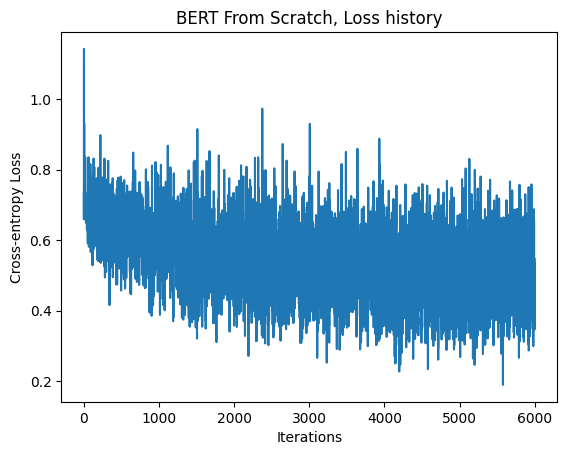

In [27]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT From Scratch, Loss history')
plt.show()

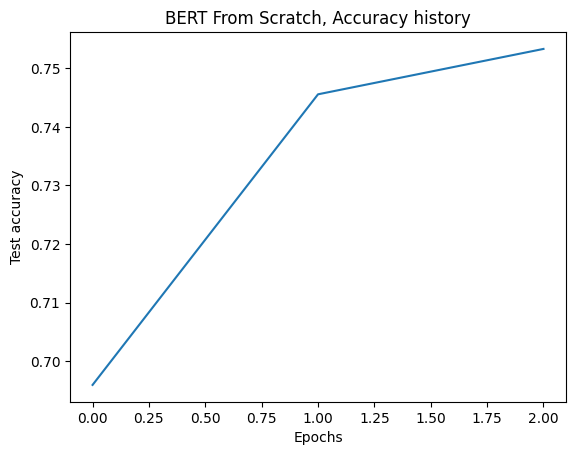

In [28]:
plt.plot(acc_history)
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.title('BERT From Scratch, Accuracy history')
plt.show()

Once again, let's make our trained model classify some sample tweets!!

In [29]:
# Replace the string below by your own.
sample_tweet = 'My Doordash delivery is 30 minutes late:( Ughh, I am hungry!!!'

predicted_label = classify_tweet(sample_tweet, our_model, device, finetuning=False)
classification = 'positive' if predicted_label == 1 else 'negative'
print(f'Your tweet was classified as {classification}.')

Your tweet was classified as negative.
